In [1]:
# This notebook is for voxel-wise correlation of functional and structural gradients (multimodal - struct x func).

# Includes:
#     laoding gradient data
#     checking and saving resampled (to 1.6mm matching func) diffusion gradients
#     BF color coding by coordinate system
#     gradient correlations (struct x func)
#     joint fig of gradient correlation and distribution histogram
#     residuals calculation ie BF subregion most different in struct vs. func gradients

In [3]:
import os
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn import preprocessing
from scipy.stats import linregress
from copy import copy

### Setting the path

In [6]:
main_path = "/srv/khan/users/sudesnac/"
#main_path = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/"

In [7]:
# get the current notebook path
note_path = main_path + "/HumanBF-Parcellation/notebook/"
data_path = main_path + "/HumanBF-Parcellation/data/"
results_path = main_path + "/HumanBF-Parcellation/results/Grad_corr/"
fig_path = main_path + "/HumanBF-Parcellation/results/figures/Grad_corr/"

In [8]:
Func_results_path = main_path + "/HumanBF-Parcellation/results/Func_HCPMMP/"
Diff_results_path = main_path + "/HumanBF-Parcellation/results/Diff_7Tsubj7TDWI/"

### Checking & saving resampled dMRI data matched to rfMRI resolution

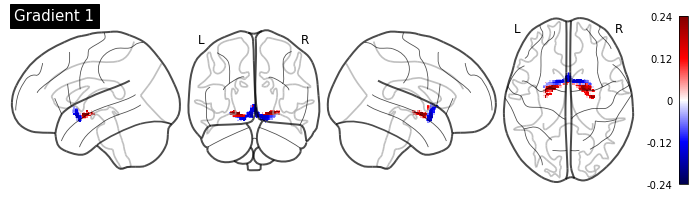

In [12]:
# Checking resampled diffusion gradients
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_roi
# display figures
gradi = 0
grad_nib = nib.load(results_path + f'Diff_resampled_gradient_{gradi}.nii.gz')
color = matplotlib.cm.get_cmap('seismic')
plot_glass_brain(grad_nib, colorbar=True, title=(f'Gradient '+ str(gradi+1)), display_mode='lyrz', plot_abs=False, cmap=color)

In [13]:
# saving resampled diff gradients to data frame
DiffRIdx_df = pd.DataFrame()
for gradi in range(5):
    grad_nib = nib.load(results_path + f'Diff_resampled_gradient_{gradi}.nii.gz').get_fdata()
    DiffR_idx = np.argwhere(grad_nib)
    DiffR_values = grad_nib[DiffR_idx[:,0], DiffR_idx[:,1], DiffR_idx[:,2]]
    DiffRIdx_df[str(gradi)] = pd.DataFrame(DiffR_values)

In [14]:
# saving the data frame to csv file
pd.DataFrame(DiffRIdx_df).to_csv(results_path + 'Diff_resampled_gradients_seed-BASF_1p6mm.csv', index=False)

### Loading BF data (nii files)

In [9]:
rfmri_fname = (Func_results_path + 'Func_HCPMMP_gradient_{0}.nii.gz')
dmri_fname = (results_path + 'Diff_resampled_gradient_{0}.nii.gz')

In [10]:
rfmri_g1_nii  = nib.load(rfmri_fname.format(0))
dmri_g1_nii = nib.load(dmri_fname.format(0))

In [11]:
rfmri_g1 = rfmri_g1_nii.get_fdata()
rfmri_mask = np.where(rfmri_g1, 1, 0)

dmri_g1  = dmri_g1_nii.get_fdata()
dmri_mask = np.where(dmri_g1, 1, 0)

#### Creating combined mask and color-coded BF

In [12]:
combined_mask = np.zeros_like(dmri_mask)
combined_mask[(dmri_mask==1) & (rfmri_mask==1)] = 1

In [13]:
# Get X, Y, Z coordinates
ijk_indices = np.argwhere(combined_mask)
ijk_indices = np.hstack((ijk_indices,np.ones((len(ijk_indices),1))))

affine = rfmri_g1_nii.affine

xyz_coords = np.dot(ijk_indices, affine)

In [14]:
# Here we flip along the X axis to give left and right same color codes
new_ijk_indices = ijk_indices.copy()
new_ijk_indices[:,0] = np.abs((combined_mask.shape[0]/2)-ijk_indices[:,0])

In [15]:
# Create RGB array
min_max_scaler = preprocessing.MinMaxScaler()

c_com = np.zeros((len(new_ijk_indices),3))
c_com[:,0] = min_max_scaler.fit_transform(new_ijk_indices[:,0][:,np.newaxis])[:,0]
c_com[:,1] = min_max_scaler.fit_transform(new_ijk_indices[:,1][:,np.newaxis])[:,0]
c_com[:,2] = min_max_scaler.fit_transform(new_ijk_indices[:,2][:,np.newaxis])[:,0]

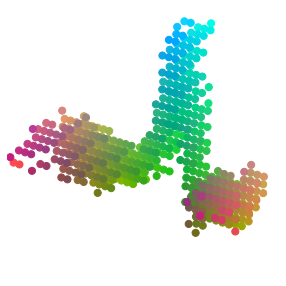

In [16]:
# combined functional x diffusion mask for func vs. diff correlation
fig = plt.figure(figsize=(10,5))
ax2 = fig.add_subplot(projection='3d')
ax2.dist=6
ax2.set_axis_off()

ax2.scatter(
    ijk_indices[:,0],
    ijk_indices[:,1],
    ijk_indices[:,2],
    s=50, alpha=1,
    c=c_com
)

plt.show()

### Gradient Correlation structural vs functional - all gradients Rs 

#### Linear least-square regression

In [23]:
r2_matrix = np.zeros((5,5))
r_matrix = np.zeros((5, 5))
p_matrix = np.zeros((5, 5))
reg_results = pd.DataFrame()
dmri_rescaled = pd.DataFrame()
rfmri_rescaled = pd.DataFrame()

for g in range(0,5):
    dmri_g = nib.load(dmri_fname.format(g)).get_fdata()
    dmri_g_rescaled = min_max_scaler.fit_transform(dmri_g[combined_mask==1][:,np.newaxis])
    dmri_rescaled[g] = pd.DataFrame(dmri_g_rescaled)

    for gg in range(0,5):
        rfmri_g = nib.load(rfmri_fname.format(gg)).get_fdata()
        rfmri_g_rescaled = min_max_scaler.fit_transform(rfmri_g[combined_mask==1][:,np.newaxis])
        rfmri_rescaled[gg] = pd.DataFrame(rfmri_g_rescaled)
        
        res = linregress(dmri_g[combined_mask==1].flatten(), rfmri_g[combined_mask==1].flatten())
        
        reg_results[g,gg] = pd.DataFrame(res)
        r2_matrix[g,gg] = res.rvalue**2
        r_matrix[g,gg] = res.rvalue
        p_matrix[g,gg] = res.pvalue
        
index = pd.Index(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'])
reg_results = reg_results.set_index(index)       

In [24]:
pd.DataFrame(reg_results).to_csv(results_path + 'Struct_vs_Func_linear_least-squares_regression_results_scipy.csv', index=False)
pd.DataFrame(dmri_rescaled).to_csv(results_path + 'BF_Structural_gradients_rescaled-0to1.csv', index=False)
pd.DataFrame(rfmri_rescaled).to_csv(results_path + 'BF_Functional_gradients_rescaled-0to1.csv', index=False)

In [25]:
# Define the gradient labels so it starts from 1 instead of 0
x_axis_labels = [1,2,3,4,5] # labels for x-axis
y_axis_labels = [1,2,3,4,5] # labels for y-axis

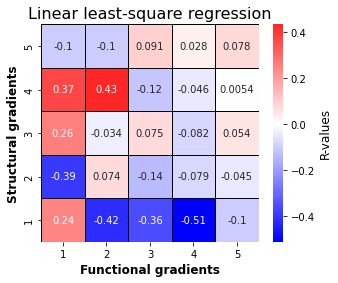

In [26]:
# plot r-values
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(r_matrix, cmap='bwr', center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'R-values'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Linear least-square regression', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_linear_least-squares_regression_R-values.png', dpi=300)
plt.show()

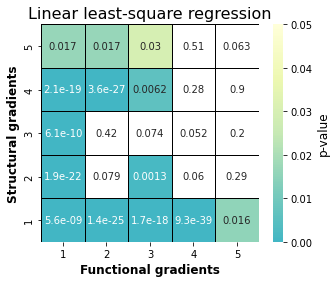

In [27]:
# plot significant p-values
from copy import copy
#conditions for filtering p<=0.05
val_max = 0.05

fig, ax = plt.subplots(1,1, figsize=(5,4))

#define the colormap with clipping values
my_cmap = copy(plt.cm.YlGnBu_r)
my_cmap.set_over("white")
my_cmap.set_under("white")

sns.heatmap(p_matrix, vmax=val_max, cmap=my_cmap, center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'p-value'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.invert_yaxis()
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Linear least-square regression', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_linear_least-squares_regression_p-values.png', dpi=300)
plt.show()

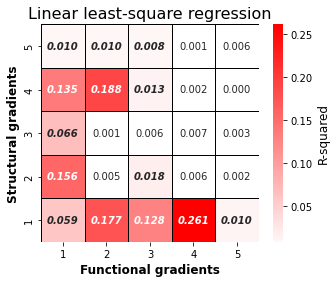

In [28]:
val_min = 0.008

# plot r-squared
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(r2_matrix, mask=r2_matrix > val_min, cmap=ListedColormap(['white']), center=0, linewidth=1, linecolor='black', square=True,
           cbar=False,annot = True, fmt=".3f",
            xticklabels=x_axis_labels, yticklabels=y_axis_labels)
sns.heatmap(r2_matrix, mask=r2_matrix < val_min, cmap='bwr', center=0, linewidth=1, linecolor='black', square=True,
            cbar_kws={'label':'R-squared'}, annot = True, fmt=".3f", annot_kws={"style": "italic","weight": "bold"},
            xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Linear least-square regression', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_linear_least-squares_regression_R-squared_scipy-sigbold.png', dpi=300)
plt.show()

In [29]:
# average of R-squared over all 5x5 gradients
print(r2_matrix.mean())
print(r_matrix.mean())

0.05118454488003333
-0.03274865310044297


#### Pearson correlation

In [30]:
from scipy import stats
pcorr_matrix = np.zeros((5,5))
pp_matrix = np.zeros((5, 5))
pr2_matrix = np.zeros((5, 5))

for g in range(0,5):
    dmri_g = nib.load(dmri_fname.format(g)).get_fdata()
    dmri_g_rescaled = min_max_scaler.fit_transform(dmri_g[combined_mask==1][:,np.newaxis])    

    for gg in range(0,5):
        rfmri_g = nib.load(rfmri_fname.format(gg)).get_fdata()
        rfmri_g_rescaled = min_max_scaler.fit_transform(rfmri_g[combined_mask==1][:,np.newaxis])
        
        pearsonr, pearsonp = stats.pearsonr(dmri_g[combined_mask==1].flatten(), rfmri_g[combined_mask==1].flatten())
        
        pcorr_matrix[g,gg] = pearsonr
        pp_matrix[g,gg] = pearsonp
        pr2_matrix[g,gg] = pearsonr**2

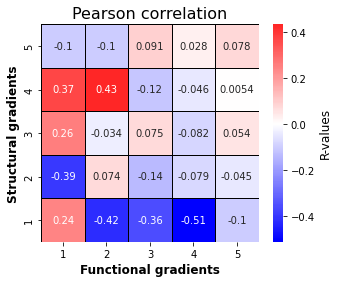

In [31]:
# plot pearson r-values
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(pcorr_matrix, cmap='bwr', center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'R-values'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Pearson correlation', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_pearson_correlation_R-values.png', dpi=300)
plt.show()

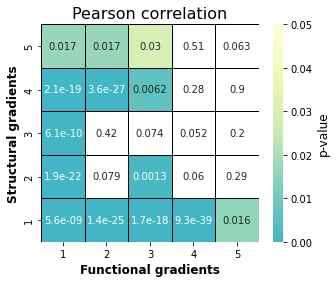

In [32]:
# plot pearson p-values
from copy import copy
#conditions for filtering p<=0.05
val_max = 0.05

fig, ax = plt.subplots(1,1, figsize=(5,4))

#define the colormap with clipping values
my_cmap = copy(plt.cm.YlGnBu_r)
my_cmap.set_over("white")
my_cmap.set_under("white")

sns.heatmap(pp_matrix, vmax=val_max, cmap=my_cmap, center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'p-value'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Pearson correlation', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_pearson_correlation_p-values.png', dpi=300)
plt.show()

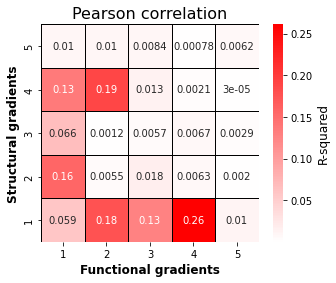

In [33]:
# plot pearson r-squared-values
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(pr2_matrix, cmap='bwr', center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'R-squared'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Pearson correlation', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_pearson_correlation_R-squared.png', dpi=300)
plt.show()

#### Spearman correlation

In [34]:
from scipy import stats
spearmanr_matrix = np.zeros((5,5))
spearmanp_matrix = np.zeros((5, 5))
spearmanr2_matrix = np.zeros((5, 5))

for g in range(0,5):
    dmri_g = nib.load(dmri_fname.format(g)).get_fdata()
    dmri_g_rescaled = min_max_scaler.fit_transform(dmri_g[combined_mask==1][:,np.newaxis])    

    for gg in range(0,5):
        rfmri_g = nib.load(rfmri_fname.format(gg)).get_fdata()
        rfmri_g_rescaled = min_max_scaler.fit_transform(rfmri_g[combined_mask==1][:,np.newaxis])
        
        spearmanr, spearmanp = stats.spearmanr(dmri_g[combined_mask==1].flatten(), rfmri_g[combined_mask==1].flatten())
        
        spearmanr_matrix[g,gg] = spearmanr
        spearmanp_matrix[g,gg] = spearmanp
        spearmanr2_matrix[g,gg] = spearmanr**2

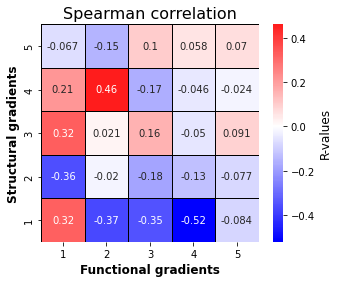

In [35]:
# plot pearson r-values
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(spearmanr_matrix, cmap='bwr', center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'R-values'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Spearman correlation', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_spearman_correlation_R-values.png', dpi=300)
plt.show()

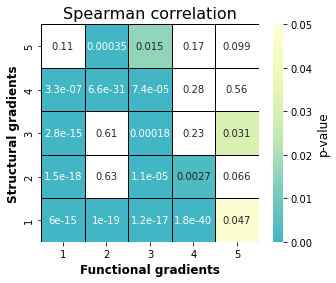

In [36]:
# plot pearson p-values
from copy import copy
#conditions for filtering p<=0.05
val_max = 0.05

fig, ax = plt.subplots(1,1, figsize=(5,4))

#define the colormap with clipping values
my_cmap = copy(plt.cm.YlGnBu_r)
my_cmap.set_over("white")
my_cmap.set_under("white")

sns.heatmap(spearmanp_matrix, vmax=val_max, cmap=my_cmap, center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'p-value'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Spearman correlation', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_spearman_correlation_p-values.png', dpi=300)
plt.show()

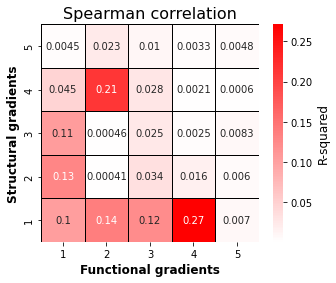

In [37]:
# plot pearson r-squared-values
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(spearmanr2_matrix, cmap='bwr', center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'R-squared'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Spearman correlation', fontsize=16)
plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_spearman_correlation_R-squared.png', dpi=300)
plt.show()

In [38]:
# average of R over all 5x5 gradients
spearmanr_matrix.mean()

-0.0310775718942307

In [39]:
# average of R-squared over all 5x5 gradients
spearmanr2_matrix.mean()

0.05201426664547446

### Structural vs Functional gradient correlations

#### Correlation SG1 vs. FG1 (specify G)

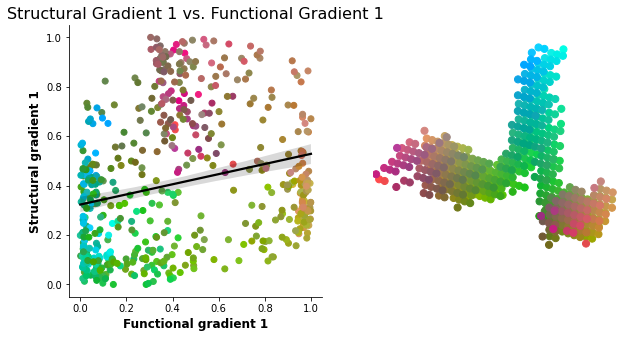

In [41]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)

ax1.scatter(rfmri_rescaled, dmri_rescaled, c=c_com)

ax1.set_xlabel('Functional gradient 1', weight='bold', fontsize=12)
ax1.set_ylabel('Structural gradient 1', weight='bold', fontsize=12)

plt.title("Structural Gradient 1 vs. Functional Gradient 1", fontsize=16)
# Add fit line
sns.regplot(
    x=rfmri_rescaled,
    y=dmri_rescaled,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

# Add 3D scatterplot for visualizing RGB values
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.dist=6
ax2.set_axis_off()

ax2.scatter(
    ijk_indices[:,0],
    ijk_indices[:,1],
    ijk_indices[:,2],
    s=50, alpha=1,
    c=c_com
)

plt.show()

#### Structural vs Functional correlation for G1 to G5

In [42]:
# load the data
struct_rescaled = pd.read_csv(results_path + 'BF_Structural_gradients_rescaled-0to1.csv')
func_rescaled = pd.read_csv(results_path + 'BF_Functional_gradients_rescaled-0to1.csv')

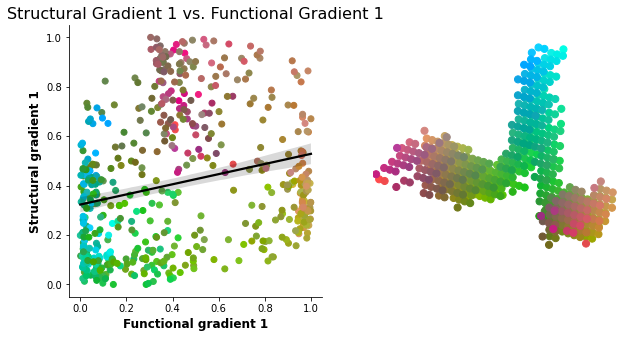

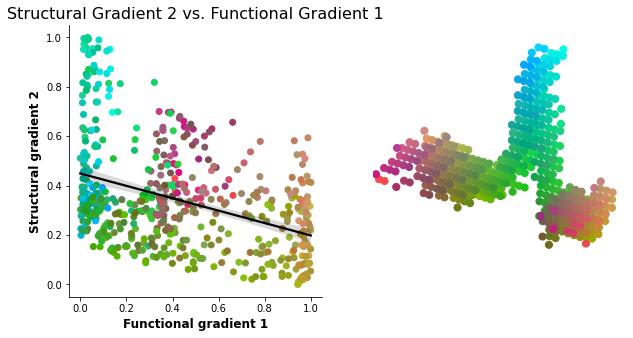

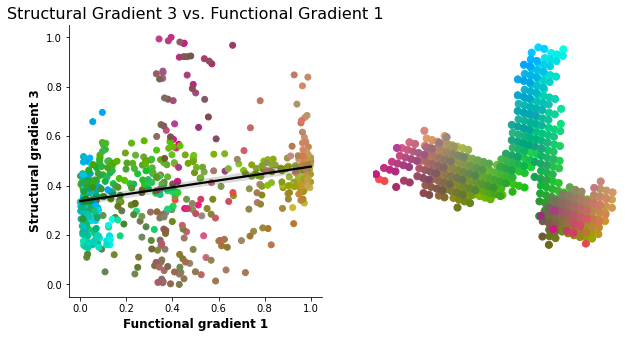

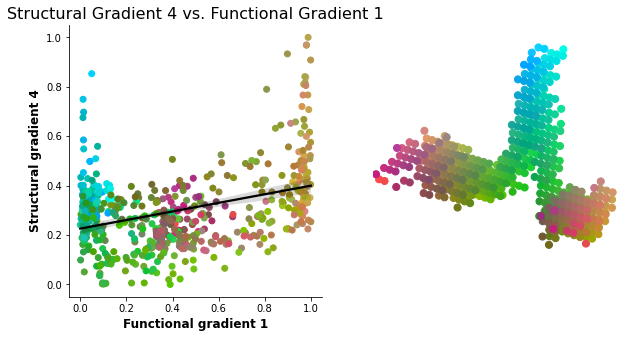

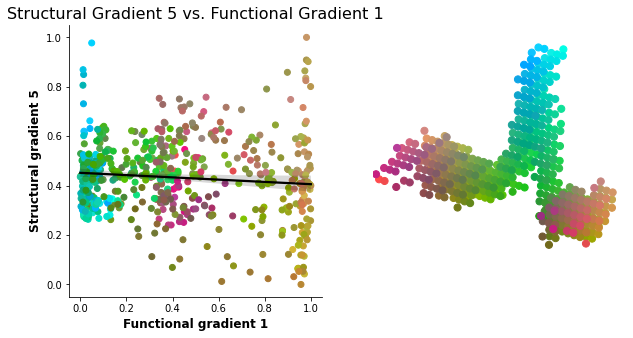

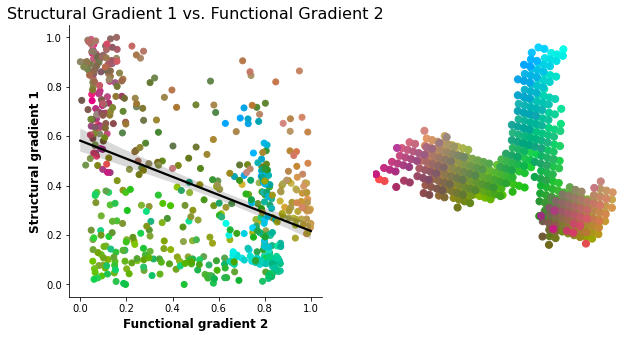

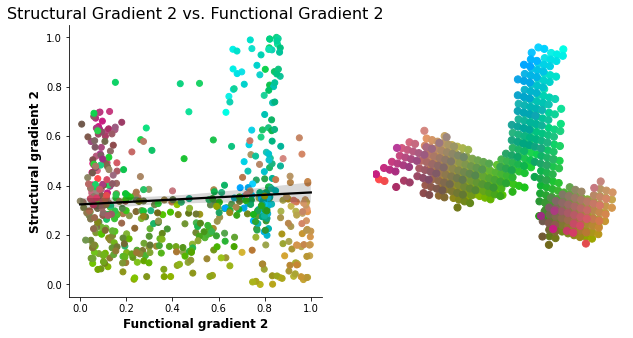

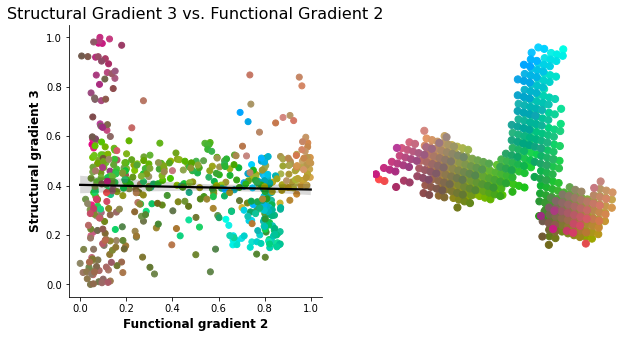

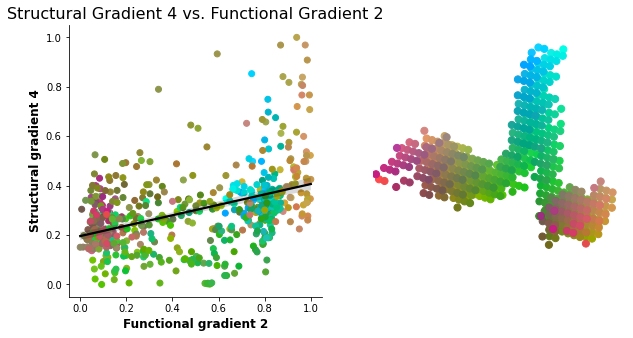

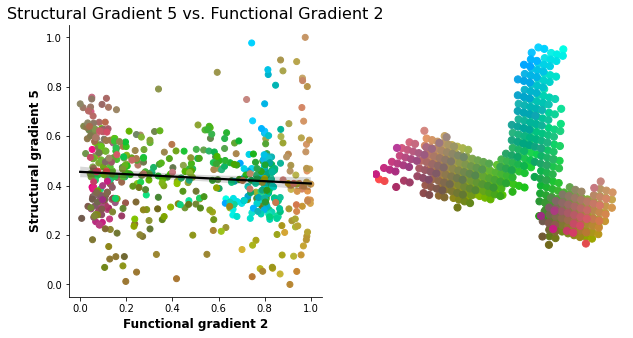

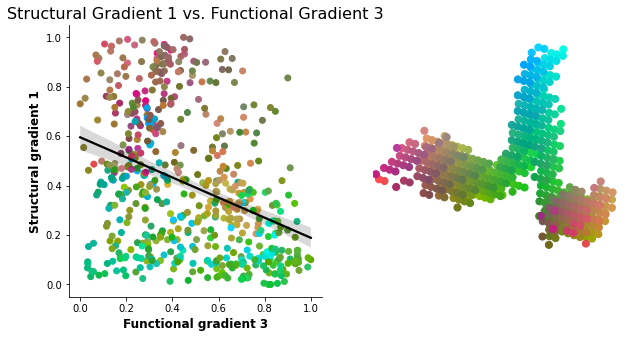

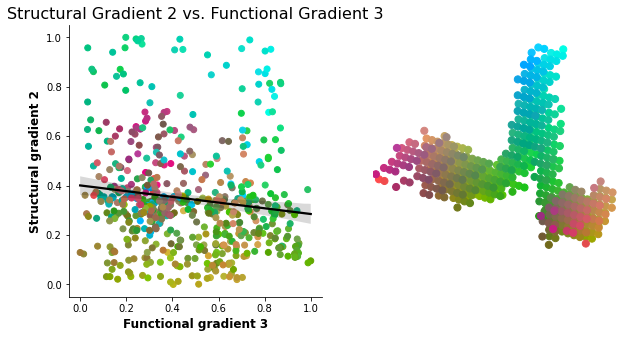

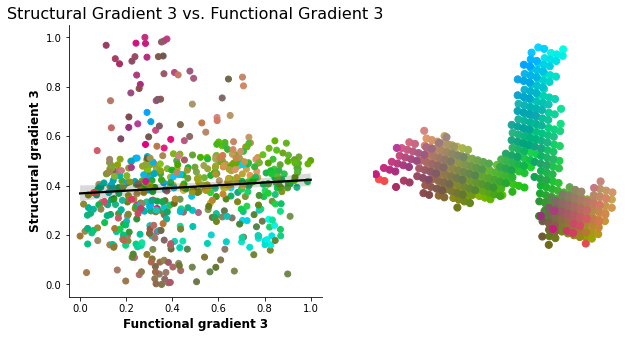

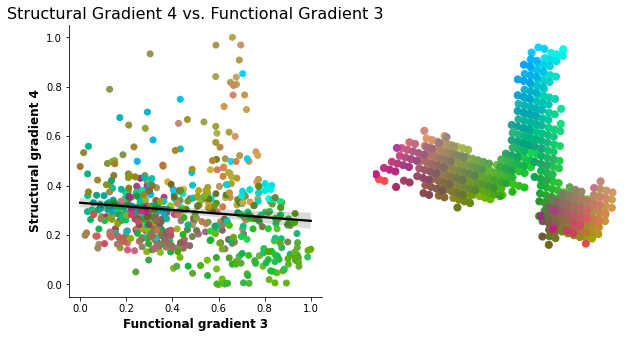

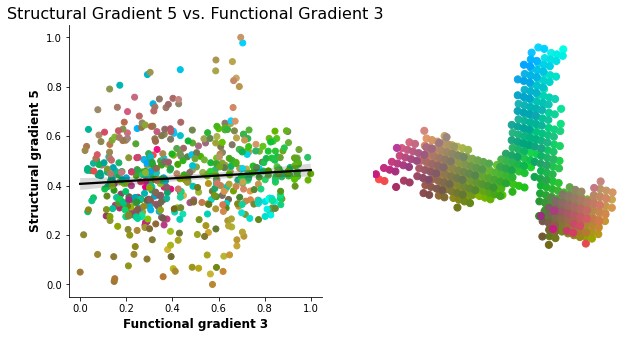

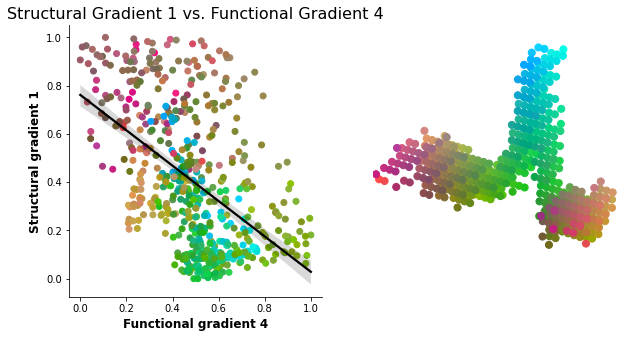

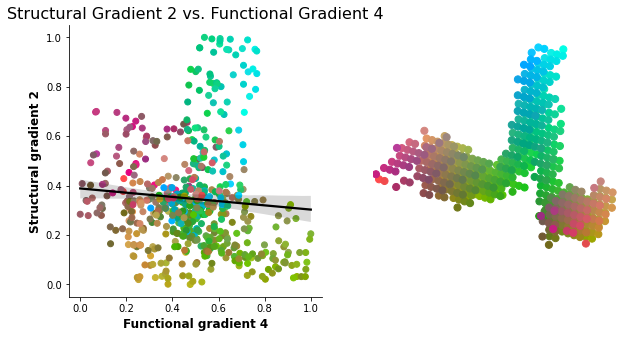

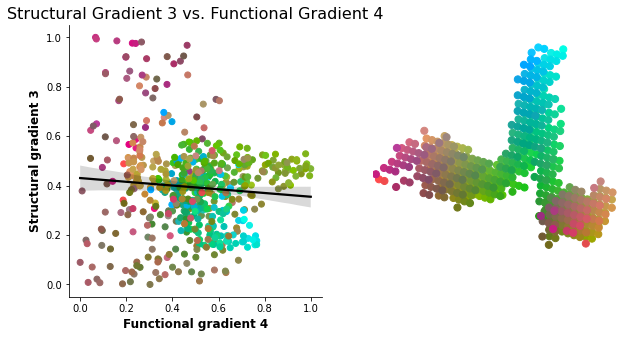

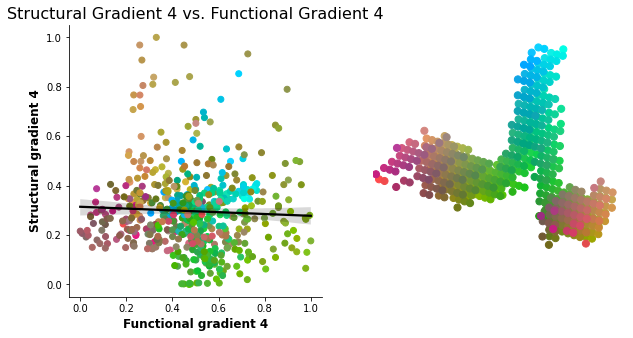

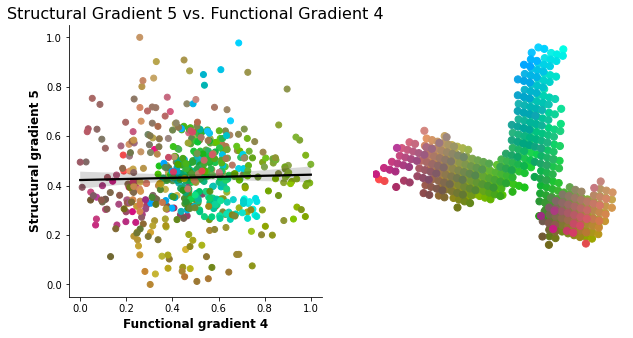

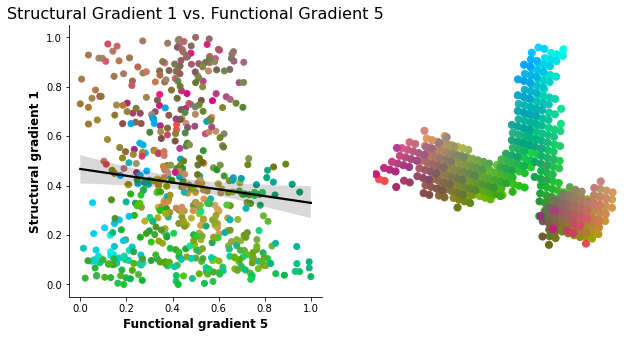

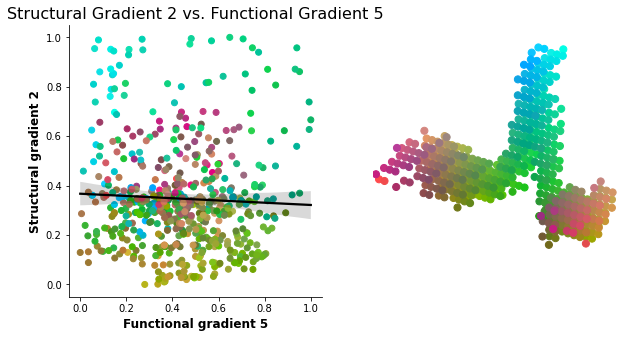

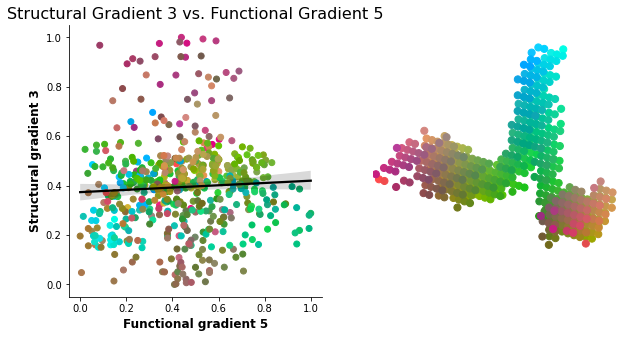

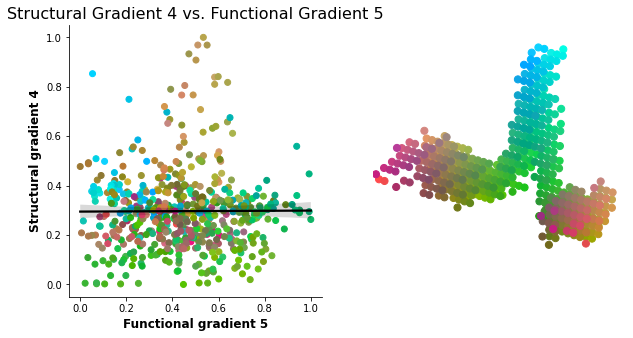

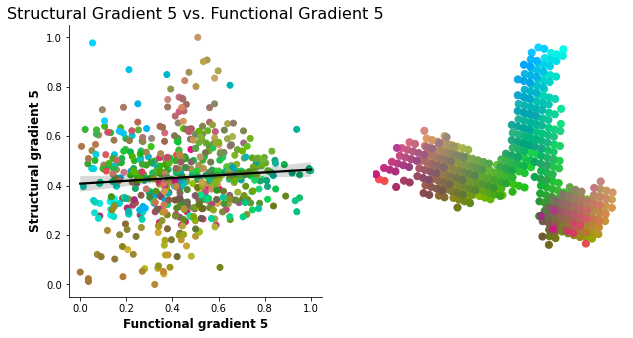

In [43]:
for fg in range(0,5):
    for dg in range(0,5):
        # Plot scatterplot colorcoded for XYZ coordinates
        fig = plt.figure(figsize=(10,5))
        ax1 = fig.add_subplot(1,2,1)
        
        x=func_rescaled[str(fg)].to_numpy()
        y=struct_rescaled[str(dg)].to_numpy()
        
        ax1.scatter(x,y,c=c_com)
        
        ax1.set_xlabel("Functional gradient "+str(fg+1), weight='bold', fontsize=12)
        ax1.set_ylabel("Structural gradient "+str(dg+1), weight='bold', fontsize=12)

        plt.title("Structural Gradient " + str(dg+1) + " vs. Functional Gradient " + str(fg+1), fontsize=16)
        
        # Add fit line
        sns.regplot(
            x=x,
            y=y,
            scatter=False, line_kws={'color': 'black'},
            ax=ax1)
        sns.despine()
                
        # Add 3D scatterplot for visualizing RGB values
        ax2 = fig.add_subplot(1,2,2, projection='3d')
        ax2.dist=6
        ax2.set_axis_off()
        ax2.scatter(ijk_indices[:,0],ijk_indices[:,1],ijk_indices[:,2],s=50, alpha=1,c=c_com)
        
        plt.savefig(fig_path + f'BF_Gradient_Struct_g-'+str(dg+1)+'_vs_Func_g-'+str(fg+1)+'_scaled-0to1.png', dpi=300)
        plt.show()

#### Structural vs Functional correlation and distribution

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:1670: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


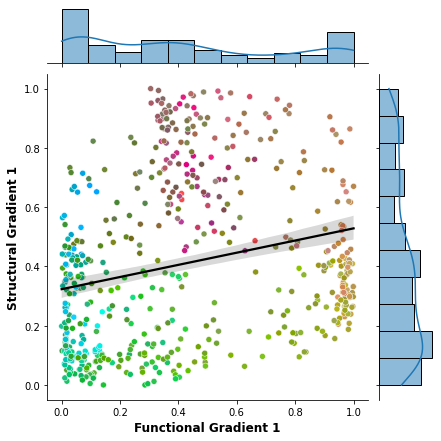

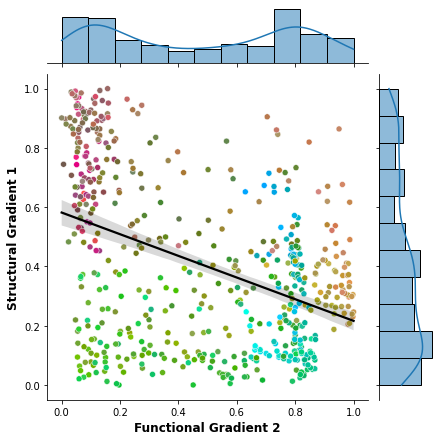

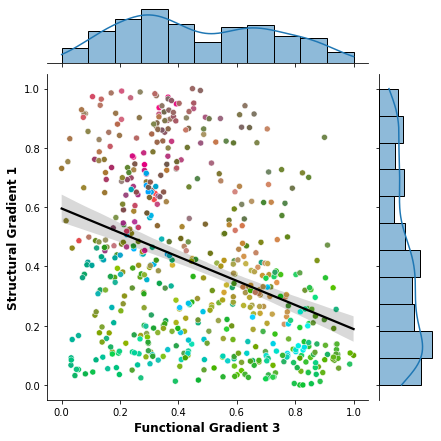

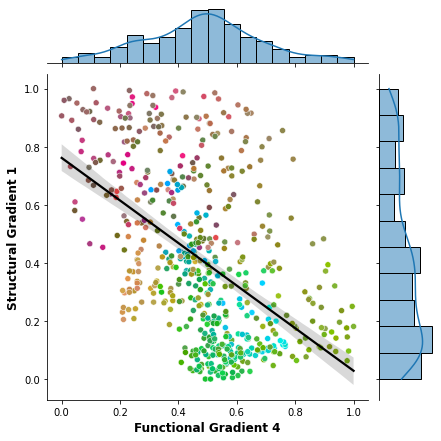

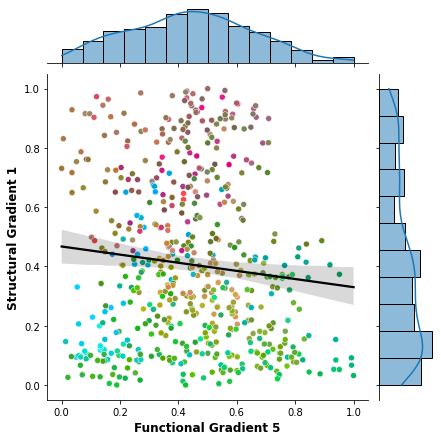

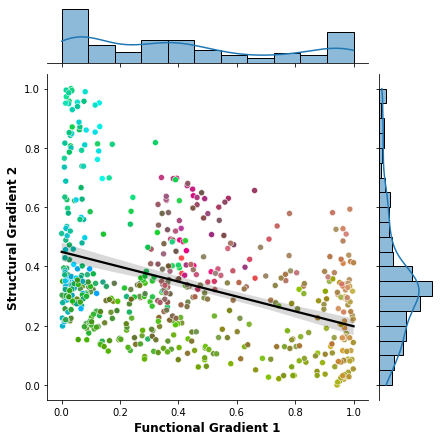

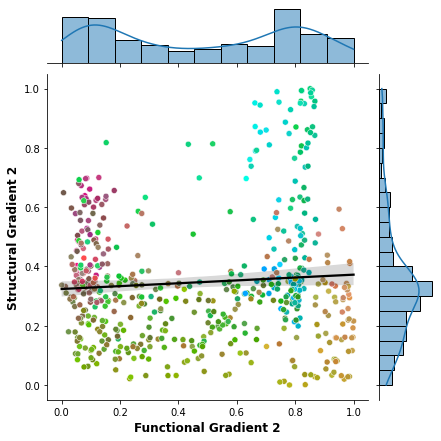

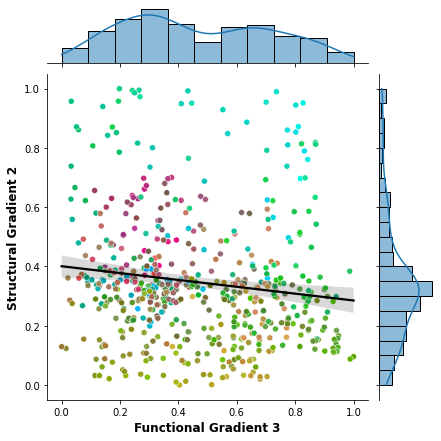

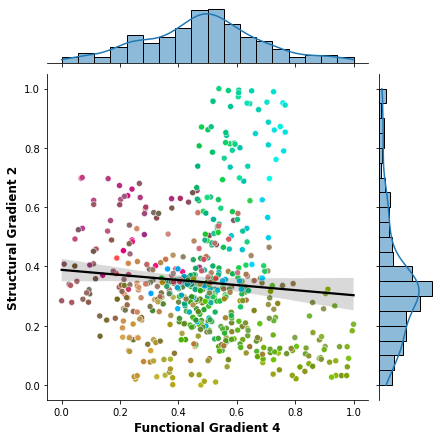

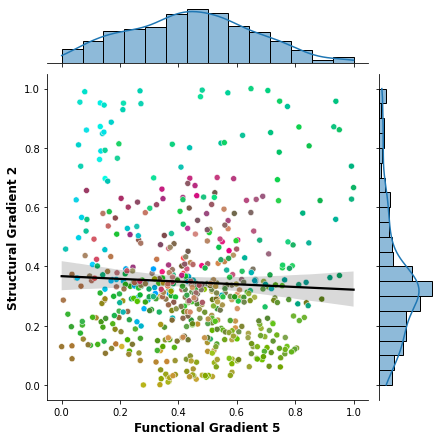

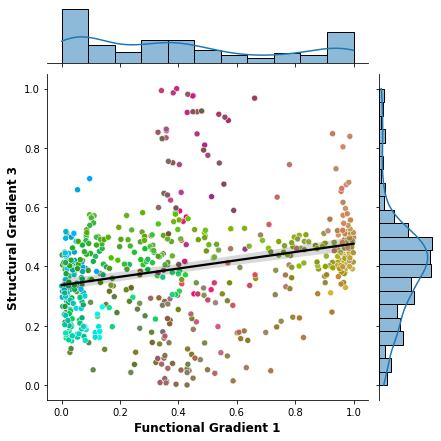

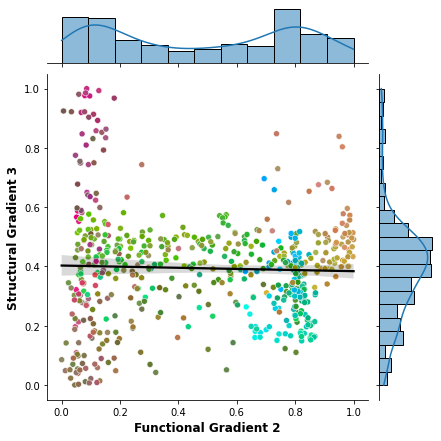

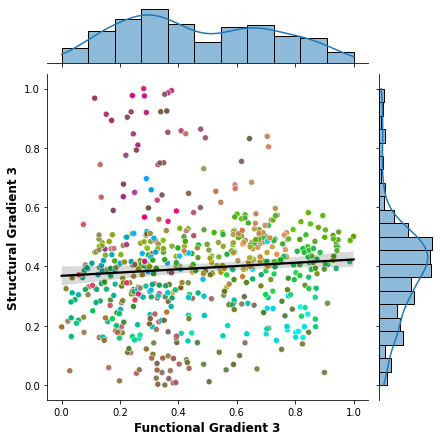

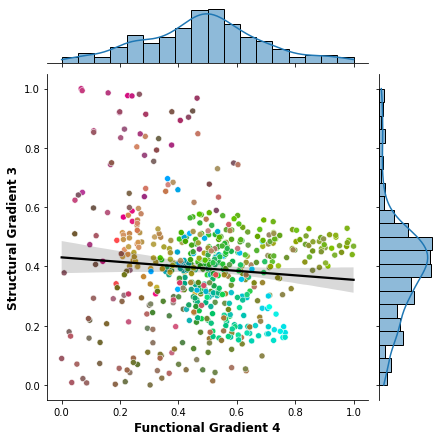

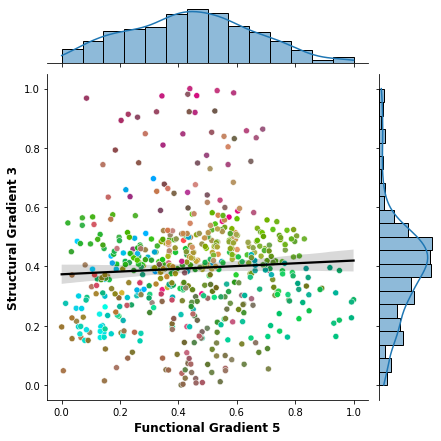

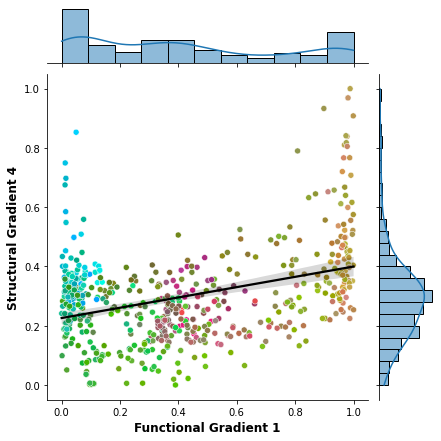

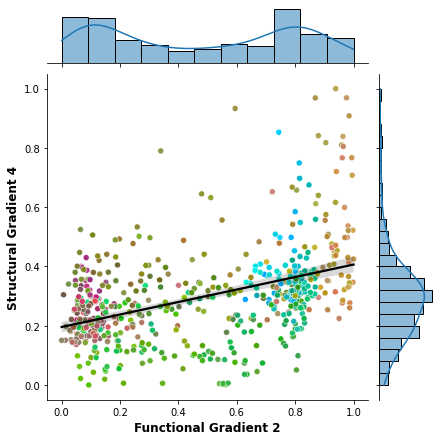

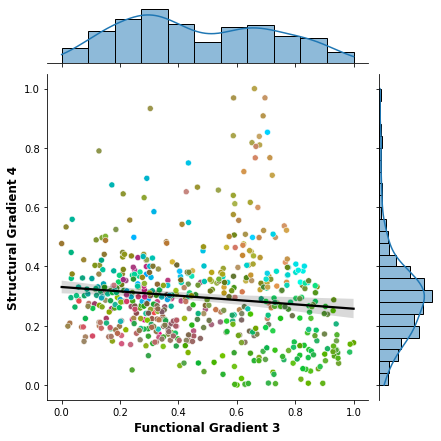

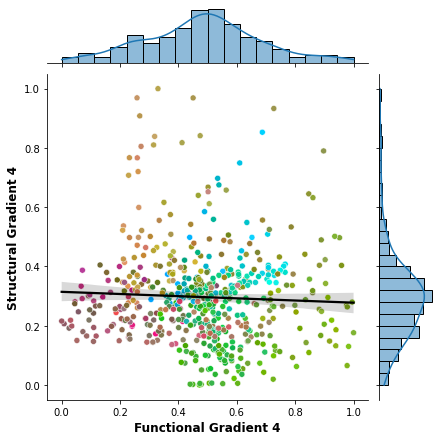

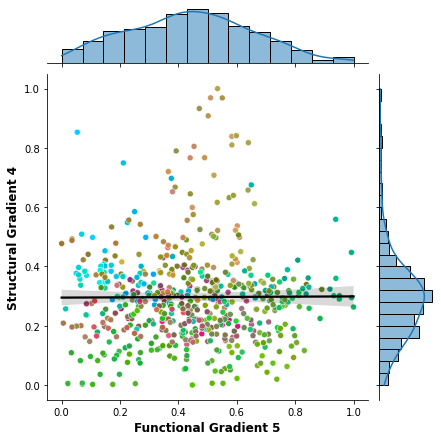

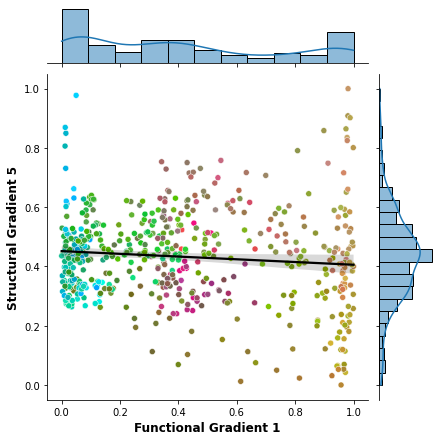

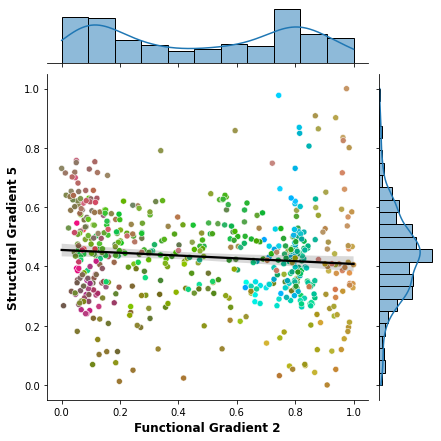

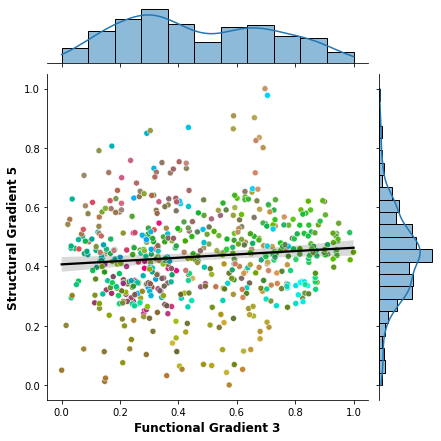

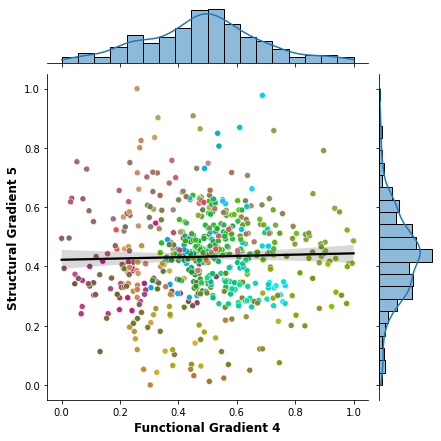

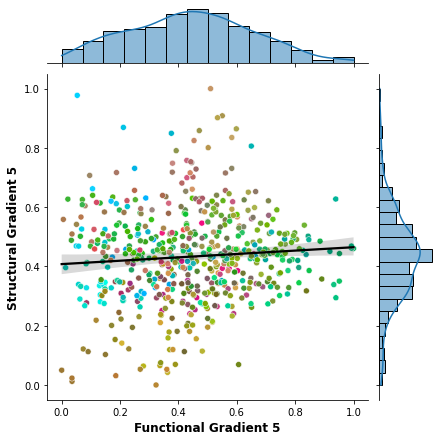

In [44]:
for dg in range(0,5): 
    for fg in range(0,5):
        
        x=func_rescaled[str(fg)].to_numpy()
        y=struct_rescaled[str(dg)].to_numpy()
        
        g = sns.JointGrid(x=x, y=y)
        g.plot_joint(sns.scatterplot, c=c_com)
        g.plot_marginals(sns.histplot, kde=True)
        g1 = sns.regplot(x=x, y=y, scatter=False, line_kws={'color': 'black'}, ax=g.ax_joint)
        g.set_axis_labels(xlabel=f'Functional Gradient '+str(fg+1), ylabel=f'Structural Gradient '+str(dg+1), weight='bold', fontsize=12)
        g.savefig(fig_path + f'BF_resampled&scaled_Gradients_correlation_and_distribution_Structural_g-'+ str(dg+1)+'_vs_Functional_g-'+ str(fg+1)+'.png', dpi=300)

### Calculating residuals

In [45]:
# load the data
rfmri_fname = (Func_results_path + 'Func_HCPMMP_gradient_{0}.nii.gz')
dmri_fname = (results_path + 'Diff_resampled_gradient_{0}.nii.gz')

In [46]:
rsq_matrix = np.zeros((5,5))
resid_results = pd.DataFrame()

import statsmodels.api as sm
for dg in range(0,5):
    dmri_g = nib.load(dmri_fname.format(dg)).get_fdata()

    for fg in range(0,5):
        rfmri_g = nib.load(rfmri_fname.format(fg)).get_fdata()
        
        model = sm.OLS(rfmri_g[combined_mask==1].flatten(), dmri_g[combined_mask==1].flatten())
        results = model.fit()
        
        rsq_matrix[dg,fg] = results.rsquared
        resid_results[dg,fg] = pd.DataFrame(results.resid)

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


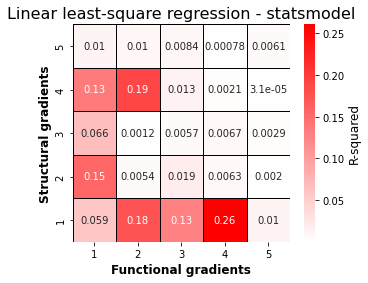

In [47]:
# plot r-squared to double check
fig, ax = plt.subplots(1,1, figsize=(5,4))
# Define the gradient labels so it starts from 1 instead of 0
x_axis_labels = [1,2,3,4,5] # labels for x-axis
y_axis_labels = [1,2,3,4,5] # labels for y-axis
sns.heatmap(rsq_matrix, cmap='bwr', center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'R-squared'}, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.invert_yaxis()
ax.set_ylabel('Structural gradients', weight='bold', fontsize=12)
ax.set_xlabel('Functional gradients', weight='bold', fontsize=12)
ax.set_title('Linear least-square regression - statsmodel', fontsize=16)
#plt.savefig(fig_path + f'BF_Gradient_Struct_vs_Func_linear_least-squares_regression_R-squared_statsmodels.png', dpi=300)
plt.show()

In [48]:
pd.DataFrame(resid_results).to_csv(results_path + 'Struct_vs_Func_linear_least-squares_regression_residuals_statsmodels.csv', index=False)

In [18]:
resid_results = pd.read_csv(results_path + 'Struct_vs_Func_linear_least-squares_regression_residuals_statsmodels.csv')
resid_results

(0, 0)    (0, 1)    (0, 2)    (0, 3)    (0, 4)    (1, 0)    (1, 1)  \
0   -0.028715 -0.083054 -0.006727 -0.025396 -0.000413  0.018042 -0.116924   
1   -0.046074 -0.049852  0.003692  0.002648  0.004433  0.029535 -0.123026   
2   -0.000191 -0.073638 -0.010252  0.006573 -0.004094  0.049384 -0.123002   
3   -0.025670 -0.086484 -0.007712 -0.026574 -0.000521  0.004737 -0.115805   
4   -0.033448 -0.076694 -0.007300 -0.018597  0.008962  0.031882 -0.124842   
..        ...       ...       ...       ...       ...       ...       ...   
558  0.247340  0.120160  0.013245 -0.030462 -0.004807  0.183848  0.138755   
559  0.250965  0.124191  0.016890 -0.031182 -0.000568  0.208275  0.142463   
560  0.234038  0.135172  0.016820 -0.025720 -0.004339  0.183179  0.139425   
561  0.246621  0.138155  0.020445 -0.026971  0.000212  0.236421  0.141980   
562  0.099146 -0.094194 -0.037663  0.008169 -0.018627  0.108250 -0.103770   

       (1, 2)    (1, 3)    (1, 4)  ...    (3, 0)    (3, 1)    (3, 2)  \
0   -0.012762 -0.034418 -0.001223  ...  0.014114 -0.103361 -0.014676   
1   -0.011829 -0.018836  0.002303  ...  0.060375 -0.088884 -0.014853   
2   -0.020863 -0.008032 -0.005552  ...  0.071697 -0.100237 -0.022802   
3   -0.013920 -0.035173 -0.001373  ...  0.018624 -0.100843 -0.015229   
4   -0.015990 -0.031512  0.007794  ...  0.033625 -0.101083 -0.018963   
..        ...       ...       ...  ...       ...       ...       ...   
558  0.012862 -0.028475 -0.004929  ...  0.179673  0.088835  0.019087   
559  0.018439 -0.027684 -0.000392  ...  0.082932  0.020163  0.028616   
560  0.013181 -0.028115 -0.004910  ...  0.096391  0.026130  0.023901   
561  0.020646 -0.026338  0.000230  ...  0.144751  0.065014  0.026487   
562 -0.039771  0.005295 -0.018918  ...  0.113399 -0.099236 -0.040127   

       (3, 3)    (3, 4)    (4, 0)    (4, 1)    (4, 2)    (4, 3)    (4, 4)  
0   -0.035331 -0.001383  0.002266 -0.112785 -0.014330 -0.035163 -0.001590  
1   -0.020091  0.002244  0.028908 -0.114340 -0.014295 -0.019731  0.001459  
2   -0.008824 -0.005576  0.051040 -0.117031 -0.022505 -0.008605 -0.006136  
3   -0.035714 -0.001395  0.008940 -0.109357 -0.015632 -0.035742 -0.002009  
4   -0.032890  0.007587  0.003337 -0.123882 -0.016985 -0.032196  0.007765  
..        ...       ...       ...       ...       ...       ...       ...  
558 -0.025592 -0.004499  0.223845  0.124193  0.017984 -0.026174 -0.003603  
559 -0.023569 -0.000307  0.265335  0.156530  0.015920 -0.027942 -0.001890  
560 -0.023552 -0.004585  0.231050  0.129844  0.017099 -0.026159 -0.004087  
561 -0.024075  0.000176  0.266183  0.155328  0.017637 -0.027083 -0.001136  
562  0.005156 -0.018916  0.110499 -0.101809 -0.040267  0.005142 -0.019113  

[563 rows x 25 columns]

In [19]:
resid_square_results = resid_results**2
resid_square_results

(0, 0)    (0, 1)    (0, 2)    (0, 3)        (0, 4)    (1, 0)  \
0    8.245377e-04  0.006898  0.000045  0.000645  1.708659e-07  0.000326   
1    2.122788e-03  0.002485  0.000014  0.000007  1.964740e-05  0.000872   
2    3.657381e-08  0.005423  0.000105  0.000043  1.675871e-05  0.002439   
3    6.589500e-04  0.007480  0.000059  0.000706  2.713805e-07  0.000022   
4    1.118737e-03  0.005882  0.000053  0.000346  8.031300e-05  0.001016   
..            ...       ...       ...       ...           ...       ...   
558  6.117714e-02  0.014438  0.000175  0.000928  2.310949e-05  0.033800   
559  6.298326e-02  0.015423  0.000285  0.000972  3.224071e-07  0.043379   
560  5.477369e-02  0.018271  0.000283  0.000662  1.882401e-05  0.033555   
561  6.082189e-02  0.019087  0.000418  0.000727  4.495629e-08  0.055895   
562  9.829851e-03  0.008872  0.001418  0.000067  3.469642e-04  0.011718   

       (1, 1)    (1, 2)    (1, 3)        (1, 4)  ...    (3, 0)    (3, 1)  \
0    0.013671  0.000163  0.001185  1.496016e-06  ...  0.000199  0.010684   
1    0.015135  0.000140  0.000355  5.302544e-06  ...  0.003645  0.007900   
2    0.015129  0.000435  0.000065  3.082387e-05  ...  0.005140  0.010048   
3    0.013411  0.000194  0.001237  1.884267e-06  ...  0.000347  0.010169   
4    0.015586  0.000256  0.000993  6.074040e-05  ...  0.001131  0.010218   
..        ...       ...       ...           ...  ...       ...       ...   
558  0.019253  0.000165  0.000811  2.429421e-05  ...  0.032282  0.007892   
559  0.020296  0.000340  0.000766  1.540126e-07  ...  0.006878  0.000407   
560  0.019439  0.000174  0.000790  2.411290e-05  ...  0.009291  0.000683   
561  0.020158  0.000426  0.000694  5.282200e-08  ...  0.020953  0.004227   
562  0.010768  0.001582  0.000028  3.578730e-04  ...  0.012859  0.009848   

       (3, 2)    (3, 3)        (3, 4)    (4, 0)    (4, 1)    (4, 2)    (4, 3)  \
0    0.000215  0.001248  1.911779e-06  0.000005  0.012721  0.000205  0.001236   
1    0.000221  0.000404  5.035484e-06  0.000836  0.013074  0.000204  0.000389   
2    0.000520  0.000078  3.109572e-05  0.002605  0.013696  0.000506  0.000074   
3    0.000232  0.001275  1.946852e-06  0.000080  0.011959  0.000244  0.001278   
4    0.000360  0.001082  5.755834e-05  0.000011  0.015347  0.000289  0.001037   
..        ...       ...           ...       ...       ...       ...       ...   
558  0.000364  0.000655  2.023676e-05  0.050107  0.015424  0.000323  0.000685   
559  0.000819  0.000555  9.439939e-08  0.070403  0.024502  0.000253  0.000781   
560  0.000571  0.000555  2.101902e-05  0.053384  0.016859  0.000292  0.000684   
561  0.000702  0.000580  3.089350e-08  0.070853  0.024127  0.000311  0.000733   
562  0.001610  0.000027  3.578325e-04  0.012210  0.010365  0.001621  0.000026   

       (4, 4)  
0    0.000003  
1    0.000002  
2    0.000038  
3    0.000004  
4    0.000060  
..        ...  
558  0.000013  
559  0.000004  
560  0.000017  
561  0.000001  
562  0.000365  

[563 rows x 25 columns]

In [20]:
resid_square_sum = resid_square_results.sum(axis=1)
resid_square_sum

0      0.064815
1      0.064805
2      0.075568
3      0.064447
4      0.071234
         ...   
558    0.305851
559    0.313068
560    0.277133
561    0.354904
562    0.119700
Length: 563, dtype: float64

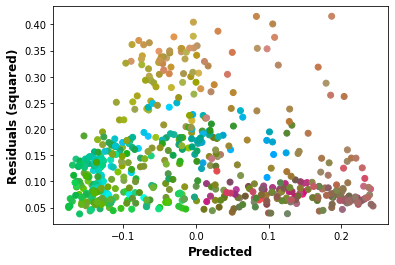

In [23]:
import matplotlib.pyplot as plt
gradi=0
dmri_g = nib.load(dmri_fname.format(gradi)).get_fdata()
plt.scatter(dmri_g[combined_mask==1].flatten(), resid_square_sum, c=c_com)
plt.xlabel('Predicted', weight='bold', fontsize=12)
plt.ylabel('Residuals (squared)', weight='bold', fontsize=12)
#plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.savefig(fig_path + f'Average_residuals_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
resid_sqsum = resid_square_sum.to_numpy()

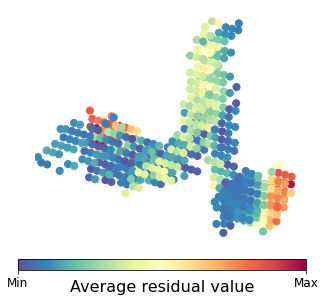

In [54]:
fig = plt.figure(figsize=(10,5))
ax2 = fig.add_subplot(projection='3d')
ax2.dist=6
ax2.set_axis_off()

ax2.scatter(
    ijk_indices[:,0],
    ijk_indices[:,1],
    ijk_indices[:,2],
    s=50, alpha=1,
    cmap='Spectral_r',
    c=resid_sqsum
)

# Add legend    
norm = matplotlib.colors.Normalize(vmin=0, vmax=2.2)

cb_ax = fig.add_axes([0.3, 0.15, 0.4, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Spectral_r), ticks=[0, 2.2],
                  cax=cb_ax, orientation='horizontal')
cb.set_label("Average residual value", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['Min','Max'], fontsize=12) 

plt.savefig(fig_path + f'BF_Struct_vs_Func_linear_least-squares_regression_scaled-sqsum_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

#### Max (Sig) R-squared residual

In [55]:
max_rs = resid_results['(0, 3)']

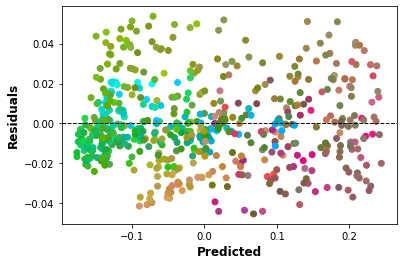

In [56]:
import matplotlib.pyplot as plt
gradi=0
dmri_g = nib.load(dmri_fname.format(gradi)).get_fdata()
plt.scatter(dmri_g[combined_mask==1].flatten(), max_rs, c=c_com)
plt.xlabel('Predicted', weight='bold', fontsize=12)
plt.ylabel('Residuals', weight='bold', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.savefig(fig_path + f'Max_sig_R-squared_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

In [57]:
max_rs_sq = max_rs**2
#max_rs_sq.to_numpy()

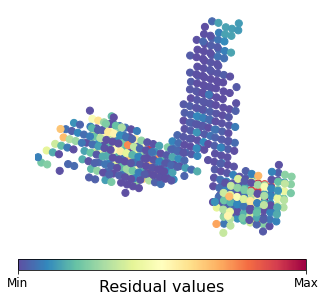

In [58]:
fig = plt.figure(figsize=(10,5))
ax2 = fig.add_subplot(projection='3d')
ax2.dist=6
ax2.set_axis_off()

ax2.scatter(
    ijk_indices[:,0],
    ijk_indices[:,1],
    ijk_indices[:,2],
    s=50, alpha=1,
    cmap='Spectral_r',
    c=max_rs_sq.to_numpy()
)

# Add legend    
norm = matplotlib.colors.Normalize(vmin=0, vmax=2.2)

cb_ax = fig.add_axes([0.3, 0.15, 0.4, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Spectral_r), ticks=[0, 2.2],
                  cax=cb_ax, orientation='horizontal')
cb.set_label("Residual values", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['Min','Max'], fontsize=12) 

plt.savefig(fig_path + f'BF_Max_sig_R-squared_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

#### Min R-squared residuals

In [59]:
# Significant min
min_sig_rs = resid_results['(4, 2)']

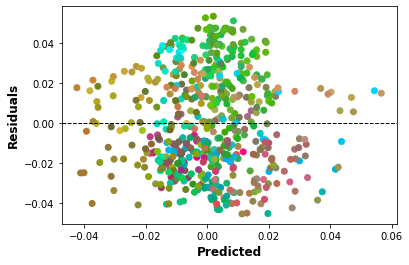

In [60]:
import matplotlib.pyplot as plt
gradi=4
dmri_g = nib.load(dmri_fname.format(gradi)).get_fdata()
plt.scatter(dmri_g[combined_mask==1].flatten(), min_sig_rs, c=c_com)
plt.xlabel('Predicted', weight='bold', fontsize=12)
plt.ylabel('Residuals', weight='bold', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.savefig(fig_path + f'Min_sig_R-squared_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

In [61]:
min_sig_rs_sq = min_sig_rs**2

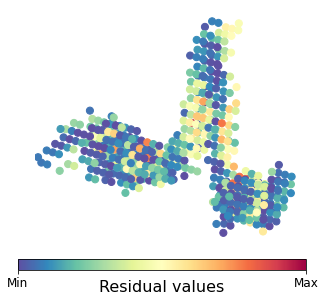

In [62]:
fig = plt.figure(figsize=(10,5))
ax2 = fig.add_subplot(projection='3d')
ax2.dist=6
ax2.set_axis_off()

ax2.scatter(
    ijk_indices[:,0],
    ijk_indices[:,1],
    ijk_indices[:,2],
    s=50, alpha=1,
    cmap='Spectral_r',
    c=min_sig_rs_sq.to_numpy()
)

# Add legend    
norm = matplotlib.colors.Normalize(vmin=0, vmax=2.2)

cb_ax = fig.add_axes([0.3, 0.15, 0.4, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Spectral_r), ticks=[0, 2.2],
                  cax=cb_ax, orientation='horizontal')
cb.set_label("Residual values", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['Min','Max'], fontsize=12) 

plt.savefig(fig_path + f'BF_Min_sig_R-squared_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

In [63]:
# NON-significant min
min_rs = resid_results['(3, 4)']

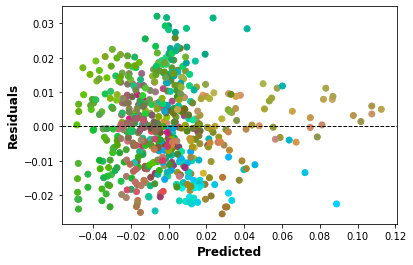

In [64]:
import matplotlib.pyplot as plt
gradi=3
dmri_g = nib.load(dmri_fname.format(gradi)).get_fdata()
plt.scatter(dmri_g[combined_mask==1].flatten(), min_rs, c=c_com)
plt.xlabel('Predicted', weight='bold', fontsize=12)
plt.ylabel('Residuals', weight='bold', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.savefig(fig_path + f'Min_non-sig_R-squared_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

In [65]:
min_rs_sq = min_rs**2

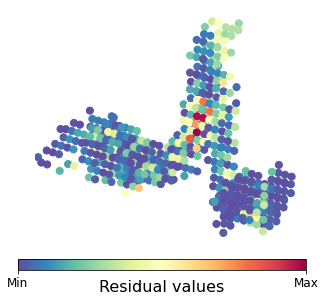

In [66]:
fig = plt.figure(figsize=(10,5))
ax2 = fig.add_subplot(projection='3d')
ax2.dist=6
ax2.set_axis_off()

ax2.scatter(
    ijk_indices[:,0],
    ijk_indices[:,1],
    ijk_indices[:,2],
    s=50, alpha=1,
    cmap='Spectral_r',
    c=min_rs_sq.to_numpy()
)

# Add legend    
norm = matplotlib.colors.Normalize(vmin=0, vmax=2.2)

cb_ax = fig.add_axes([0.3, 0.15, 0.4, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Spectral_r), ticks=[0, 2.2],
                  cax=cb_ax, orientation='horizontal')
cb.set_label("Residual values", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['Min','Max'], fontsize=12) 

plt.savefig(fig_path + f'BF_Min_non-sig_R-squared_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

#### Residual in atlas subregions

In [67]:
subBF_nib = nib.load(data_path+'fullBF_MNI6Asym_1p6mm_dseg.nii.gz')
subBF_vol = subBF_nib.get_fdata()

Ch123_nib = nib.load(data_path+'BFCh123_MNI6Asym_1p6mm.nii.gz')
Ch123_vol = Ch123_nib.get_fdata()
resid_Ch123 = np.zeros(Ch123_vol.shape)

Ch4_nib = nib.load(data_path+'BFCh4_MNI6Asym_1p6mm.nii.gz')
Ch4_vol = Ch4_nib.get_fdata()
resid_Ch4 = np.zeros(Ch4_vol.shape)

Ch4p_nib = nib.load(data_path+'BFCh4p_MNI6Asym_1p6mm.nii.gz')
Ch4p_vol = Ch4p_nib.get_fdata()
resid_Ch4p = np.zeros(Ch4p_vol.shape)

In [68]:
resid_vol = np.zeros(combined_mask.shape)
resid_vol[ijk_indices[:,0].astype(int),ijk_indices[:,1].astype(int),ijk_indices[:,2].astype(int)] = resid_sqsum

In [69]:
resid_vol.shape

(113, 136, 113)

In [70]:
resid_Ch123 = resid_vol[subBF_vol == 1]
resid_Ch4 = resid_vol[subBF_vol == 2]
resid_Ch4p = resid_vol[subBF_vol == 3]

In [71]:
resid = [resid_Ch123, resid_Ch4, resid_Ch4p]

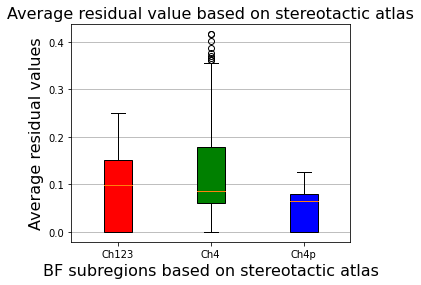

<Figure size 432x288 with 0 Axes>

In [73]:
labels = ['Ch123', 'Ch4', 'Ch4p']

fig, ax = plt.subplots(1, figsize=(5, 4))

# rectangular box plot
bplot = ax.boxplot(resid,
                   vert=True,  # vertical box alignment
                   patch_artist=True,  # fill with color
                   labels=labels)  # will be used to label x-ticks
ax.set_title('Average residual value based on stereotactic atlas', fontsize=16)

# fill with colors
colors = ['red', 'green', 'blue']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# adding horizontal grid lines
ax.yaxis.grid(True)
ax.set_xlabel('BF subregions based on stereotactic atlas', fontsize=16)
ax.set_ylabel('Average residual values', fontsize=16)

plt.show()
plt.savefig(fig_path+f'Average_residual_x_atlas.png')